<a href="https://colab.research.google.com/github/ishanashastri/transformers_from_scratch/blob/main/1_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning Curriculum [Transformers](https://github.com/jacobhilton/deep_learning_curriculum/blob/master/1-Transformers.md)


* What is different architecturally from the Transformer, vs a normal RNN, like an LSTM? (Specifically, how are recurrence and time managed?)
 * *A normal RNN uses BPTT and requires you to keep track of the entire (or some segment of) the past tokens. The Transformer instead processes all tokens in parallel, which means that it requires positional encoding to keep track of which tokens are placed where (since it's not longer sequential), and it no longer requires such massive backprop steps. In the transformer, it leverages attention to learn how different words interact with each other along different time positions in the sequence.*


* Attention is defined as, Attention(Q,K,V) = softmax($\frac{QK^T}{\sqrt{d_k}}$)V. What are the dimensions for Q, K, and V? Why do we use this setup? What other combinations could we do with (Q,K) that also output weights?
 * *Q and K have the same dimensions, being [batch_size, seq_len, $d_k$]. V has dimension of [batch_size, seq_len, $d_v$]. The hidden dimension $d_v = d_k = d\_model/n\_heads$ in the original paper. We first calculate how much each query attends to each key, getting us an attention matrix of how much each word should pay attention to each other word. We then normalize and softmax to get a probability matrix, and multiply it by our values to get our contextualized tokens. We use this setup to easily linearize the calculations as a form of matrix multiplication. We can also do non scaled dot product, which is just QK or probably any other type of scaling, since our weights are just the application of the attending Q onto our inputs K.
* Are the dense layers different at each multi-head attention block? Why or why not?
  * *They're the same architecture but I like to think of it like layers of a CNN. Each sees the entire input but learns a different feature set.*
* Why do we have so many skip connections, especially connecting the input of an attention function to the output? Intuitively, what if we didn't?
  * *To avoid overfitting and information degradation by allowing for multiple channels for the inputs to "flow" through in the network.*

In [1]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, pre_tokenizers, trainers, processors, decoders
from tokenizers.models import BPE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use GPU
else:
    device = torch.device("cpu")  # Use CPU

### Positional Embeddings

In [7]:
def calc_pos_emb(d_model, seq_len):
  '''
    implementation of fixed pos embeddings

    d_model: embedding dimension (how many dimensions to represent each token, larger -> more complexity but more computational cost), made equal so you can sum this and input embedding
    seq_len: sequence length (tracks the positions of the tokens in the sequence, usually length of input sequence or pre-maxed out at 512)
  '''
  positions = torch.empty((1, seq_len, d_model))
  div_term = 10000 ** (torch.arange(0,d_model, 2) / d_model)  # Only for even indices since odds are paired and divided by the same factors (every 2i)
  pos = torch.arange(0, seq_len).unsqueeze(1)  # Positions (seq_len, 1)

  # Apply sin to even indices and cos to odd indices
  positions[:, :, 0::2] = torch.sin(pos / div_term)  # sin for even indices
  positions[:, :, 1::2] = torch.cos(pos / div_term)  # cos for odd indices
  return torch.Tensor(positions).to(device) # dim: [seq_len, d_model]

In [8]:
pe = calc_pos_emb(64, 100)
pe.size()

torch.Size([1, 100, 64])

<ipython-input-9-0f746cd99ca9>:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  plt.imshow(pe.T.cpu().data.numpy()) # gradient display


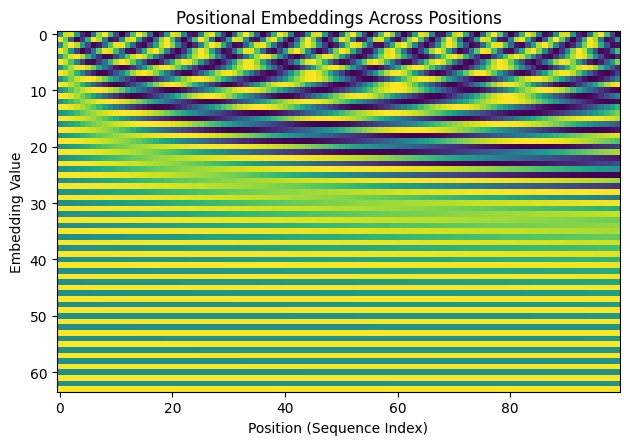

In [9]:
# plt.plot(np.arange(100), pe[:,3:7].data.numpy()) # separate lines
plt.imshow(pe.T.cpu().data.numpy()) # gradient display
plt.title("Positional Embeddings Across Positions")
plt.xlabel("Position (Sequence Index)")
plt.ylabel("Embedding Value")
plt.tight_layout()

###Attention

Each query gets dotted with the array of keys, getting us a [batch_size, seq_len, seq_len] size array that tells us how much each token attends to each other token, computing all pairwise similarities at once. These are all then normalized and softmax-ed across the last dimension, which gives us the same shape but normalizes our distribution into probabilities of each key given each query. Once we multiply this by the values matrix, we get an outputted attention matrix of shape [batch_size, seq_len, $d_v$]. This output size makes sense because for each of our batches, we want attention scores for each of our input sequence values. The attention values dimension $d_v$ tells us how many numbers will represent our attention score, so we essentially have a vector of length $d_v$ to represent the attention value at each position from 0 to seq_len in our input for that specific input position.

Our input $X$ is of shape [batch_size, seq_len, d_model] (which matches our positional encoding size). Note that the size of the embedding space actually does not affect the attention scores at all. That is because the point of attention is to inject positional relational information into our original sequence in order to preserve word-word contextual information across our seq_len. The embedding is only relevant when we actually construct our $Q, K, V$ matrices by multiplying their respective weight matrices by $X$.

Later on in multi-headed attention, we see that each head takes over a different subspace of our embedding d_model, so that our attention mechanism can operate in a smaller dimension. Even then, we don't really care about our d_model during attention, and we only ever need $d_k$ and $d_v$. After attention is complete, we concatenate heads again to get d_model as our last dimension.

---



In [10]:
def calc_attention(q, k, v, mask=None):
  '''
  Calculate single- or multi-headed attention scores given query, key, and value

  Args:
    q: query (shape: [batch_size, seq_len, d_k] for single headed or [batch_size, h, seq_len, d_k] for multi)
    k: key (shape: [batch_size, seq_len, d_k] for single headed or [batch_size, h, seq_len, d_k] for multi)
    v: value (shape: [batch_size, seq_len, d_v] for single headed or [batch_size, h, seq_len, d_v] for multi)

  Returns [batch_size, seq_len, d_v] size matrix of attention scores
  '''
  d_k = k.size()[-1]
  attention = ((q @ k.transpose(-1,-2)) / math.sqrt(d_k)) # [batch_size, seq_len, seq_len]

  if mask is not None:
    # attention = attention.masked_fill(mask != 1, -float('inf'))
    attention = attention + mask

  # note: we mask before softmax so that we force the probabilities of the unwanted positions -> 0 so they do not affect the final distributions
  return torch.softmax(attention.float(), dim=-1) @ v

In [11]:
d_k = 64
d_v = 64
batch_size = 2
seq_len = 8
q = torch.rand((batch_size, seq_len, d_k))
k = torch.rand((batch_size, seq_len, d_k))
v = torch.rand((batch_size, seq_len, d_v))

uma = calc_attention(q, k, v)
x = torch.rand((batch_size, seq_len, d_v))
# print(uma)
print(uma.size()) # should be [2, 8, 64]

torch.Size([2, 8, 64])


In [12]:
# sanity check
gt_uma = torch.nn.functional.scaled_dot_product_attention(q, k, v)
torch.allclose(uma, gt_uma)

True

Text(0, 0.5, 'Seq position')

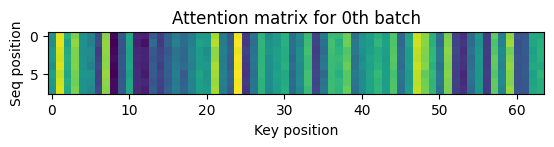

In [13]:
plt.imshow(uma[1,:,:].numpy())
plt.title("Attention matrix for 0th batch")
plt.xlabel("Key position")
plt.ylabel("Seq position")

### Masking

Note that in encoder-decoder models, the encoder can see the entire input (so as to form cross-attention representations) while the decoder is only able to see the previous tokens (so as to learn how to predict the next tokens). Thus, masking is only relevant for the decoder blocks of the model.

In [14]:
def calc_mask(seq_len, batch_size):
  mask_shape = (seq_len, seq_len)
  diag_mask = torch.triu(torch.ones(mask_shape), diagonal=1) # diagonal starts at 1 to represent all words from the next index onwards
  diag_mask = diag_mask.masked_fill(diag_mask == 1, float('-inf')) # invert mask so it only attends to previous words
  # diag_mask = diag_mask.masked_fill(diag_mask == 0, 1) # invert mask so it only attends to previous words
  return diag_mask.repeat(batch_size, 1, 1).to(device)  # repeat along batch dimension

tensor([[[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., -inf],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., -inf],
         [0., 0., 0., 0., 0., 0., 0., 0.]]])


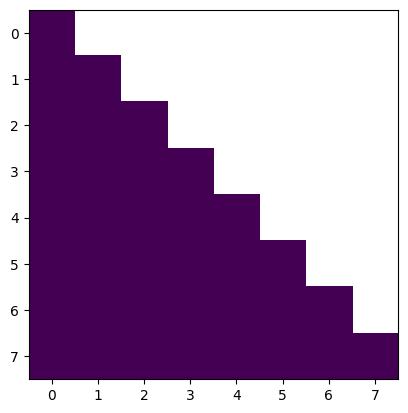

In [15]:
positional_mask = calc_mask(seq_len=8, batch_size=batch_size)
plt.imshow(positional_mask[0].cpu())
print(positional_mask)
# print(positional_mask.size())

In [16]:
c = calc_attention(q.to(device),k.to(device),v.to(device),mask=positional_mask)
c

tensor([[[0.8055, 0.5981, 0.5758,  ..., 0.3142, 0.7741, 0.8839],
         [0.8376, 0.5760, 0.5593,  ..., 0.5509, 0.8106, 0.7963],
         [0.7760, 0.6816, 0.6211,  ..., 0.4547, 0.8597, 0.6197],
         ...,
         [0.7083, 0.4859, 0.5331,  ..., 0.3919, 0.6324, 0.4477],
         [0.6588, 0.5017, 0.4866,  ..., 0.4543, 0.6252, 0.4191],
         [0.5925, 0.4471, 0.4628,  ..., 0.4328, 0.6347, 0.4125]],

        [[0.7174, 0.8504, 0.9457,  ..., 0.2503, 0.7789, 0.0791],
         [0.4922, 0.9145, 0.4668,  ..., 0.4127, 0.5808, 0.3124],
         [0.6346, 0.8907, 0.5496,  ..., 0.4757, 0.4222, 0.4704],
         ...,
         [0.6843, 0.6964, 0.5366,  ..., 0.3909, 0.4574, 0.5921],
         [0.6129, 0.7350, 0.5272,  ..., 0.3848, 0.5019, 0.6026],
         [0.5263, 0.7210, 0.5669,  ..., 0.4129, 0.5668, 0.5751]]])

In [17]:
# sanity check
gt_c = torch.nn.functional.scaled_dot_product_attention(q.to(device), k.to(device), v.to(device), attn_mask=positional_mask)
print(torch.allclose(c, gt_c))
print(gt_c)

True
tensor([[[0.8055, 0.5981, 0.5758,  ..., 0.3142, 0.7741, 0.8839],
         [0.8376, 0.5760, 0.5593,  ..., 0.5509, 0.8106, 0.7963],
         [0.7760, 0.6816, 0.6211,  ..., 0.4547, 0.8597, 0.6197],
         ...,
         [0.7083, 0.4859, 0.5331,  ..., 0.3919, 0.6324, 0.4477],
         [0.6588, 0.5017, 0.4866,  ..., 0.4543, 0.6252, 0.4191],
         [0.5925, 0.4471, 0.4628,  ..., 0.4328, 0.6347, 0.4125]],

        [[0.7174, 0.8504, 0.9457,  ..., 0.2503, 0.7789, 0.0791],
         [0.4922, 0.9145, 0.4668,  ..., 0.4127, 0.5808, 0.3124],
         [0.6346, 0.8907, 0.5496,  ..., 0.4757, 0.4222, 0.4704],
         ...,
         [0.6843, 0.6964, 0.5366,  ..., 0.3909, 0.4574, 0.5921],
         [0.6129, 0.7350, 0.5272,  ..., 0.3848, 0.5019, 0.6026],
         [0.5263, 0.7210, 0.5669,  ..., 0.4129, 0.5668, 0.5751]]])


### Multi-Headed Attention Block

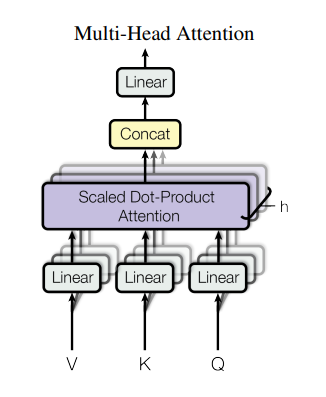

Our attention block consists of $H$ multiple heads which each operate on different subspaces of our input embedding (size $d\_model$). This makes our effective operating dimension of scaled dot-product attention far smaller and more efficient as it is now parallelized since we pass in $d_k = d_v = d\_model/h$ as our key/value/query length instead of $d\_model$. Once attention is complete, we concat all our different heads in order to recombine the disjoint input and return to our original shape in order to pass it through the rest of the model properly. Multi-head attention is just a form of compressing the dimensionality of our queries, keys, and values to make attention more efficient. Note that this is not exactly equivalent to just performing scaled DP attention on our original long input, since each subspace retains different information which is otherwise lost in the averaging of normal DP attention.

In [18]:
def multi_head_attention(q, k, v, h, mask=None):
    '''
    Calculate multi-headed attention scores given query, key, value, and number of heads

    Args:
      q: query (shape: [batch_size, seq_len, d_k]) where d_k = d_model
      k: key (shape: [batch_size, seq_len, d_k]) where d_k = d_model
      v: value (shape: [batch_size, seq_len, d_v]) where d_v = d_model
      h: number of heads
      mask: mask to apply to attention scores (optional)

    Returns [batch_size, seq_len, d_v] size matrix of attention scores
    '''

    n_batches = q.size(0)
    d_model = q.size(-1)
    d_k = d_model // h
    seq_len = q.size(-2)

    # everything should be reshaped into h separate heads
    q = q.view(n_batches, seq_len, h, d_k).transpose(1,2) # [batches, h, seq_len, d_k/h], use transpose because the original view splits the last dim of d_model=h*d_k into two dims
    k = k.view(n_batches, seq_len, h, d_k).transpose(1,2) # [batches, h, seq_len, d_k/h]
    v = v.view(n_batches, seq_len, h, d_k).transpose(1,2) # [batches, h, seq_len, d_v/h]

    attention = calc_attention(q, k, v, mask)

    # concat to original size
    attention.transpose(1,2).contiguous() # undo transpose from earlier
    attention = attention.view(n_batches, seq_len, d_model)

    # linear
    l = torch.nn.Linear(d_model, d_model).to(device) # W^O of size R^{hd_v x d_model}
    out = l(attention.to(device))

    return out # [batches, seq_len, d_model]

In [19]:
batch_size = 2
d_k = d_v = d_model = 512
seq_len = 8
h = 8
q = torch.rand((batch_size, seq_len, d_k))
k = torch.rand((batch_size, seq_len, d_k))
v = torch.rand((batch_size, seq_len, d_v))

uma = multi_head_attention(q, k, v, h)
# print(uma)
print(uma.size()) # should be [2, 8, 512] ([batch_size, seq_len, d_model])

torch.Size([2, 8, 512])


In [20]:
# sanity check
gt_uma = torch.nn.MultiheadAttention(d_model, h, bias = False, batch_first = True).to(device)
torch.allclose(uma, gt_uma(q.to(device), k.to(device), v.to(device))[0])
# note: you can't actually sanity check this without going into the pytorch code because of the weights in the linear layer........so this should be False

False

Text(0, 0.5, 'Seq position')

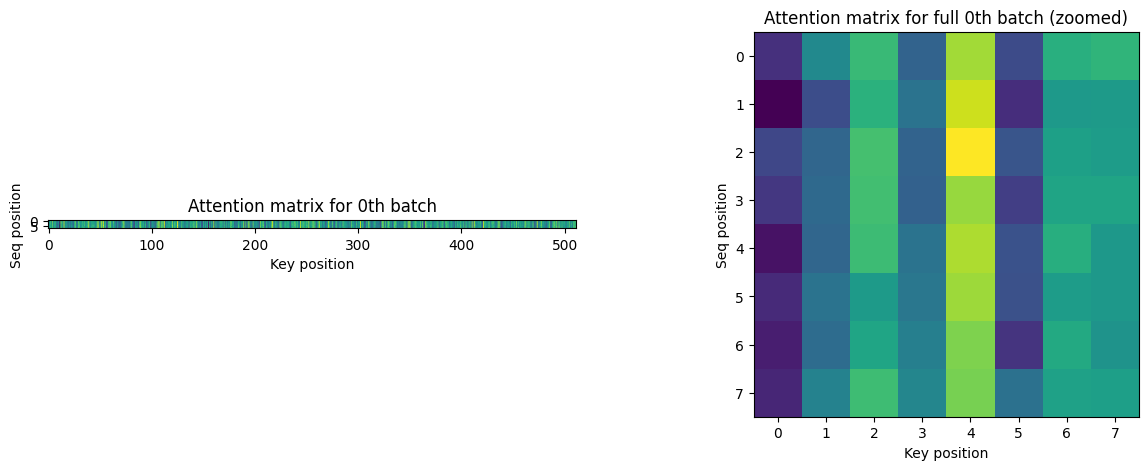

In [21]:
plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.imshow(uma[0,:,:].cpu().detach().numpy())
ax0.set_title("Attention matrix for 0th batch")
ax0.set_xlabel("Key position")
ax0.set_ylabel("Seq position")
ax1.imshow(uma[0,:,:8].cpu().detach().numpy())
ax1.set_title("Attention matrix for full 0th batch (zoomed)")
ax1.set_xlabel("Key position")
ax1.set_ylabel("Seq position")

### Building the entire decoder block

Our Decoder class represents a SINGLE decoder layer. This layer contains the MHA module, the normalization, and the position-wise FFN.

In [22]:
class Decoder(torch.nn.Module):
  def __init__(self, d_model, h):
    super().__init__()
    self.h = h
    self.d_model = d_model

    self.W_q = torch.nn.Linear(d_model, d_model)
    self.W_k = torch.nn.Linear(d_model, d_model)
    self.W_v = torch.nn.Linear(d_model, d_model)

    self.mha = multi_head_attention
    self.ln1 = torch.nn.LayerNorm(d_model)
    self.ln2 = torch.nn.LayerNorm(d_model)
    self.ff1 = torch.nn.Linear(d_model, 2048)
    self.ff2 = torch.nn.Linear(2048, d_model)
    self.relu = torch.nn.ReLU()

    self.mask = calc_mask

  def forward(self, x, pos_mask=None):
    """
    x is size [batch, seq_len, d_model], already embedded
    pos_mask is the mask for the padding positions, the attention mask is automatically applied in this function call
    """
    mask = self.mask(seq_len=x.size(-2), batch_size = x.size(0))

    if pos_mask is not None:
      mask = torch.logical_and(mask, pos_mask.unsqueeze(1)) # combine autoregressive mask and padding mask if it exists

    # duplicate mask on h heads
    mask = mask.unsqueeze(1) # add heads axis
    mask = mask.repeat(1, self.h, 1, 1) # specify how many repeats per dimension, duplicate along heads axis


    mha = self.mha(self.W_q(x).to(device), self.W_k(x).to(device), self.W_v(x).to(device), self.h, mask=mask)
    x = self.ln1(mha + x) # residual connection

    ff = self.ff2(self.relu(self.ff1(x))) # position-wise feedforward block
    x = self.ln2(ff + x) # residual connection

    return x

In [23]:
seq_len = 4
d_model = 512
h = 8
decoder = Decoder(d_model, h).to(device)

n_layers = 1
vocab = 100
x = torch.nn.Embedding(vocab, d_model)(torch.rand(1, seq_len).to(torch.int64)).to(device) # [1, seq_len]

y = decoder.forward(x)
print(f"FINAL DECODER OUTPUT SIZE: {y.size()}") # [1, seq_len, d_model]


FINAL DECODER OUTPUT SIZE: torch.Size([1, 4, 512])


The decoder only transformer creates the embedded input from our given input of size $[1, seq\_len]$, adds the positional encoding, and then passes it through all $n\_layers$ Decoder blocks to get an output of size $[n\_batches, seq\_len, d\_model]$. Then, we pass that through a linear layer to map our decoder output to logits in the vocabulary space, then we softmax along the vocabulary logits dimension to get our final probabilities. Our final output is $[n\_batches, seq\_len, vocab]$ which makes sense as it outputs the probabilities for each next word for each position in the sequence. At first, I was confused why it's of size $seq\_len$ and not just a single prediction for the next word in the sentence, but then I remembered that it's auto-regressive and we end up calculating all next words for all words in the sentence (until some stop sequence), so we see something like this:\\

```
Input: "Hi my name is"
Output (after max(probability(logits))): "my name is Ishana"
```

### Full Transformer

In [24]:
class DecoderTransformer(torch.nn.Module):
  def __init__(self, nlayers, vocab, d_model, h, device):
    super().__init__()
    self.nlayers = nlayers # each layer is a copy of the entire block from MMHA -> Norm -> FFN -> Norm
    self.h = h
    self.d_model = d_model
    self.layers = []

    for n in range(nlayers):
      self.layers.append(Decoder(d_model, h).to(device))

    self.layers = torch.nn.ModuleList(self.layers).to(device)

    self.embedding = torch.nn.Embedding(vocab, d_model).to(device) # LUT from token -> embedding
    self.linear = torch.nn.Linear(d_model, vocab).to(device)

  def forward(self, x, mask=None):
    x = self.embedding(x) + calc_pos_emb(self.d_model, x.size(-1)).to(x.device) # [batch, seq_len, d_model] + [batch, seq_len, d_model]

    for layer in self.layers:
      x = layer.forward(x, mask)

    x = self.linear(x)
    return x


In [25]:
n_layers = 6
vocab = 10
d_model = 512
h = 8
decoder = DecoderTransformer(n_layers, vocab, d_model, h, device).to(device)

n_batches = 1
seq_len = 4
x = torch.rand(n_batches, seq_len).to(torch.int64).to(device) # [n_batches, seq_len]
print(f"INPUT SIZE: {x.size()}")
print(f"TOTAL VOCABULARY: {vocab}")

y = decoder.forward(x)
print(f"EXPECTED DECODER OUTPUT SIZE: {[n_batches, seq_len, vocab]}")
print(f"FINAL DECODER OUTPUT SIZE: {y.size()}") # [n_batches, seq_len, vocab]

INPUT SIZE: torch.Size([1, 4])
TOTAL VOCABULARY: 10
EXPECTED DECODER OUTPUT SIZE: [1, 4, 10]
FINAL DECODER OUTPUT SIZE: torch.Size([1, 4, 10])


### Dummy Task Tests

Test our attention mechanisms using a simply copy-paste task and a reversing string task.

Note: we do not use dropout as in the original Vaswani paper.

In [26]:
def generate_copy_data(n_batches, seq_len, vocab):
  """Generate sample input-output pairs for simple dummy tasks."""
  x = torch.randint(0, vocab, (n_batches, seq_len)).to(torch.int64)
  # y = x.clone() # uncomment for copy paste task
  y = torch.stack([torch.flip(i, dims=[-1]) for i in x.clone()], dim=0) # uncomment for reverse string task
  return x, y

In [27]:
def train():
  losses = []
  accuracy = []
  for epoch in tqdm(range(n_epochs)):
    for step, (input, output) in enumerate(trainloader):
      input = input.to(device)
      preds = decoder.forward(input)

      # print(f"PRED SIZE: {preds.size()}") # [n_batches, seq_len, vocab]
      # print(f"OUTPUT SIZE: {output.size()}") # [n_batches, seq_len]

      preds = preds.view(-1, vocab) # convert to shape [n_batches, vocab] for loss
      output = output.view(-1) # convert to shape [n_batches]

      optimizer.zero_grad()
      l = loss(preds, output).to(device)
      l.backward()
      optimizer.step()
      scheduler.step()

      # print(f"LOSS: {l}")
      losses.append(l.cpu().detach().numpy())

      # accuracy.append((preds.argmax(dim=-1) == output).float().mean().item()) # uncomment for copy paste task
      # accuracy.append((np.argmax(preds.detach().numpy(), axis=-1) == output.detach().numpy()).sum()) # uncomment for reverse task
      accuracy.append((preds.argmax(dim=-1) == output).float().mean().item())
    print(f" ------------ EPOCH {epoch}: Accuracy: {accuracy[-1]}")
  return decoder, losses, accuracy

In [24]:
n_epochs = 20
n_batches = 64
seq_len = 16
vocab = 16

x,y = generate_copy_data(10000, seq_len, vocab)
x, y = x.to(device), y.to(device)
trainloader = torch.utils.data.DataLoader(list(zip(x,y)), batch_size=n_batches, shuffle=True)

n_layers = 6
d_model = 512
h = 8
decoder = DecoderTransformer(n_layers, vocab, d_model, h, device).to(device)

loss = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0001, betas=(0.9,0.98), eps=1e-9) #alpha = 0.001 works well for copy task, 0.0001 for reverse task
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,)

In [ ]:
model, losses, accuracy = train()

  5%|▌         | 1/20 [00:08<02:42,  8.57s/it]

 ------------ EPOCH 0: Accuracy: 0.046875


 10%|█         | 2/20 [00:17<02:34,  8.60s/it]

 ------------ EPOCH 1: Accuracy: 0.07421875


 15%|█▌        | 3/20 [00:25<02:26,  8.60s/it]

 ------------ EPOCH 2: Accuracy: 0.078125


 20%|██        | 4/20 [00:34<02:15,  8.49s/it]

 ------------ EPOCH 3: Accuracy: 0.078125


 25%|██▌       | 5/20 [00:42<02:07,  8.53s/it]

 ------------ EPOCH 4: Accuracy: 0.0546875


 30%|███       | 6/20 [00:51<01:59,  8.56s/it]

 ------------ EPOCH 5: Accuracy: 0.05078125


 35%|███▌      | 7/20 [00:59<01:50,  8.50s/it]

 ------------ EPOCH 6: Accuracy: 0.08984375


 40%|████      | 8/20 [01:08<01:42,  8.55s/it]

 ------------ EPOCH 7: Accuracy: 0.09375


 45%|████▌     | 9/20 [01:17<01:34,  8.59s/it]

 ------------ EPOCH 8: Accuracy: 0.14453125


 50%|█████     | 10/20 [01:25<01:26,  8.62s/it]

 ------------ EPOCH 9: Accuracy: 0.18359375


 55%|█████▌    | 11/20 [01:34<01:16,  8.55s/it]

 ------------ EPOCH 10: Accuracy: 0.16796875


 60%|██████    | 12/20 [01:42<01:08,  8.61s/it]

 ------------ EPOCH 11: Accuracy: 0.21484375


 65%|██████▌   | 13/20 [01:51<01:00,  8.64s/it]

 ------------ EPOCH 12: Accuracy: 0.2890625


 70%|███████   | 14/20 [02:00<00:51,  8.58s/it]

 ------------ EPOCH 13: Accuracy: 0.2578125


 75%|███████▌  | 15/20 [02:08<00:43,  8.62s/it]

 ------------ EPOCH 14: Accuracy: 0.26171875


 80%|████████  | 16/20 [02:17<00:34,  8.65s/it]

 ------------ EPOCH 15: Accuracy: 0.29296875


 85%|████████▌ | 17/20 [02:26<00:26,  8.67s/it]

 ------------ EPOCH 16: Accuracy: 0.19921875


 90%|█████████ | 18/20 [02:34<00:17,  8.60s/it]

 ------------ EPOCH 17: Accuracy: 0.3359375


 95%|█████████▌| 19/20 [02:43<00:08,  8.65s/it]

 ------------ EPOCH 18: Accuracy: 0.23828125


100%|██████████| 20/20 [02:52<00:00,  8.60s/it]

 ------------ EPOCH 19: Accuracy: 0.3125


Text(0.5, 1.0, 'Training Loss')

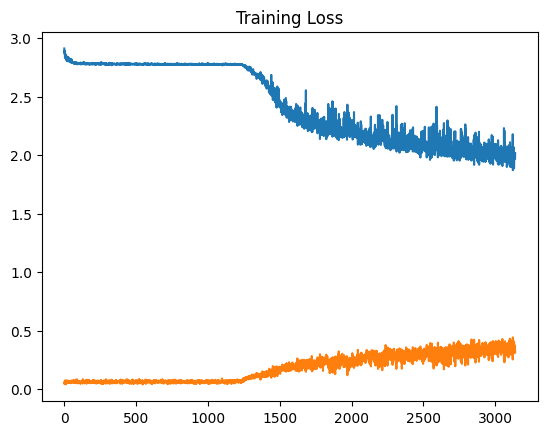

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(len(accuracy)), accuracy)
plt.title("Training Loss")

In [ ]:
test_sample = torch.randint(0, vocab, (1, 1, seq_len))
test_sample

tensor([[[ 6,  2,  0, 12,  3, 12,  7,  2,  5, 10, 12, 15,  1,  3,  9,  1]]])

In [ ]:
with torch.no_grad():
  preds = model.forward(test_sample.to(device))
  preds = torch.nn.Softmax(dim=-1)(preds)
  pred = np.argmax(preds.cpu().detach().numpy(), axis=-1) # returns indices of max probability for each token in the sequence
  print(pred) # for this task, the raw output is what we want since it's effectively already "tokenized" by virtue of just being a number sequence already
  print(f"EQUAL? : {np.allclose(pred, test_sample.detach().numpy())}")

[[[ 4  4 11  4 13  4  4  5 11  7  4  3 12  0  2  6]]]
EQUAL? : False


### Shakespeare generation

In [28]:
from urllib.request import urlopen
shakespeare = urlopen('https://www.gutenberg.org/files/100/100-0.txt').read().decode('utf-8')
print(shakespeare)

*** START OF THE PROJECT GUTENBERG EBOOK 100 ***
The Complete Works of William Shakespeare

by William Shakespeare




                    Contents

    THE SONNETS
    ALL’S WELL THAT ENDS WELL
    THE TRAGEDY OF ANTONY AND CLEOPATRA
    AS YOU LIKE IT
    THE COMEDY OF ERRORS
    THE TRAGEDY OF CORIOLANUS
    CYMBELINE
    THE TRAGEDY OF HAMLET, PRINCE OF DENMARK
    THE FIRST PART OF KING HENRY THE FOURTH
    THE SECOND PART OF KING HENRY THE FOURTH
    THE LIFE OF KING HENRY THE FIFTH
    THE FIRST PART OF HENRY THE SIXTH
    THE SECOND PART OF KING HENRY THE SIXTH
    THE THIRD PART OF KING HENRY THE SIXTH
    KING HENRY THE EIGHTH
    THE LIFE AND DEATH OF KING JOHN
    THE TRAGEDY OF JULIUS CAESAR
    THE TRAGEDY OF KING LEAR
    LOVE’S LABOUR’S LOST
    THE TRAGEDY OF MACBETH
    MEASURE FOR MEASURE
    THE MERCHANT OF VENICE
    THE MERRY WIVES OF WINDSOR
    A MIDSUMMER NIGHT’S DREAM
    MUCH ADO ABOUT NOTHING
    THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE
    PERICLES, PRINC

In [29]:
shakespeare = shakespeare.replace("                    ", " ")
paragraphs = re.split("\r\n\r\n", shakespeare) # split by large paragraphs
paragraphs = [p for p in paragraphs if p != ""]

In [30]:
len(paragraphs)

40917

### Training a BPE tokenizer for our small dataset

I originally tried using bert-base-uncased's tokenizer but i realized the vocab was just too massive (I believe vocab = ~25000 tokens) to effectively work for this tiny task, so I just trained my own from scratch.

In [31]:
# https://huggingface.co/learn/nlp-course/en/chapter6/8?fw=pt#building-a-bpe-tokenizer-from-scratch

tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

In [32]:
def get_training_corpus():
    for i in range(0, len(paragraphs), 64):
        yield paragraphs[i : i + 1000]

In [33]:
trainer = trainers.BpeTrainer(vocab_size=5000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

In [34]:
encoding = tokenizer.encode("It shall be sparing, and too full of riot.")
print(encoding.tokens)

['It', 'Ġshall', 'Ġbe', 'Ġsp', 'aring', ',', 'Ġand', 'Ġtoo', 'Ġfull', 'Ġof', 'Ġri', 'ot', '.']


In [35]:
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()

In [36]:
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<|endoftext|>",
    eos_token="<|endoftext|>",
)
wrapped_tokenizer.pad_token = wrapped_tokenizer.eos_token

In [37]:
tokens = wrapped_tokenizer(paragraphs, max_length=100, truncation=True, padding="max_length")

In [38]:
input_ids, token_type_ids, padding_mask = torch.tensor(tokens["input_ids"]), torch.tensor(tokens["token_type_ids"]), torch.tensor(tokens["attention_mask"])

In [39]:
input_ids.size(), padding_mask.size()

(torch.Size([40917, 100]), torch.Size([40917, 100]))

In [40]:
vocab = len(wrapped_tokenizer.get_vocab())
num_para = len(input_ids)
max_len = len(input_ids[0])
vocab, num_para, max_len

(5000, 40917, 100)

In [41]:
def autoreg_loss_func(preds, output):
  """
  preds: [n_batches, seq_len, vocab]
  output: [n_batches, seq_len]
  """
  preds = preds.view(-1, vocab) # convert to shape [n_batches, vocab] for loss
  output = output.contiguous().view(-1) # convert to shape [n_batches]

  return loss(preds, output).to(device)

In [42]:
def train_lg():
  losses = []
  for epoch in tqdm(range(n_epochs)):
    for step, (input, padding_mask) in enumerate(trainloader):
      output = input.clone()

      input = input[:,:-1] # [n_batches, seq_len-1], remove last token
      padding_mask = padding_mask[:,:-1] # [n_batches, seq_len-1], remove last token

      input = input.to(device)
      preds = decoder.forward(input, padding_mask.to(device))

      # print(f"PRED SIZE: {preds.size()}") # [n_batches, seq_len, vocab]
      # print(f"OUTPUT SIZE: {output.size()}") # [n_batches, seq_len]

      output = output[:, 1:] # [n_batches, seq_len-1], remove first token
      output = output.to(device)

      optimizer.zero_grad()
      l = autoreg_loss_func(preds, output)
      l.backward()
      optimizer.step()
      scheduler.step()

      # print(f"LOSS: {l}")
      if step % 500 == 0:
        losses.append(l.cpu().detach().numpy())
        # print(tokenizer.decode(preds.argmax(dim=-1)[0]))

    print(f" ------------ EPOCH {epoch}: Loss: {losses[-1]}")
  return decoder, losses

In [43]:
n_epochs = 30
n_batches = 64
seq_len = max_len
vocab = vocab

trainloader = torch.utils.data.DataLoader(list(zip(input_ids, padding_mask)), batch_size=n_batches, shuffle=True)

n_layers = 6
d_model = 512
h = 8
decoder = DecoderTransformer(n_layers, vocab, d_model, h, device).to(device)

loss = torch.nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=wrapped_tokenizer.pad_token_id) # skip padding when calculating loss
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4, betas=(0.9,0.98), eps=1e-9) #alpha = 0.001 works well for copy task, 0.0001 for reverse task
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,)

In [ ]:
model, loss = train_lg()
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, f"/content/drive/MyDrive/shakespeare_{n_epochs}.pt")

  3%|▎         | 1/30 [02:45<1:20:00, 165.52s/it]

 ------------ EPOCH 0: Loss: 5.203015327453613


  7%|▋         | 2/30 [05:35<1:18:32, 168.31s/it]

 ------------ EPOCH 1: Loss: 4.90272331237793


 10%|█         | 3/30 [08:25<1:16:05, 169.10s/it]

 ------------ EPOCH 2: Loss: 4.885096073150635


 13%|█▎        | 4/30 [11:15<1:13:25, 169.42s/it]

 ------------ EPOCH 3: Loss: 4.7949066162109375


 17%|█▋        | 5/30 [14:05<1:10:36, 169.44s/it]

 ------------ EPOCH 4: Loss: 4.7799272537231445


 20%|██        | 6/30 [16:54<1:07:49, 169.55s/it]

 ------------ EPOCH 5: Loss: 4.760437488555908


 23%|██▎       | 7/30 [19:44<1:05:01, 169.64s/it]

 ------------ EPOCH 6: Loss: 4.603226661682129


 27%|██▋       | 8/30 [22:34<1:02:13, 169.69s/it]

 ------------ EPOCH 7: Loss: 4.714479446411133


Text(0.5, 1.0, 'Training Loss')

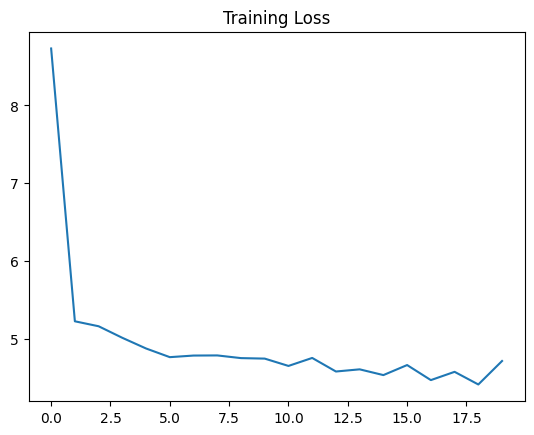

In [55]:
plt.plot(np.arange(len(loss)), loss)
plt.title("Training Loss")

In [46]:
# load from checkpoint

ckpt = torch.load('/content/drive/MyDrive/shakespeare_10.pt', map_location=device, weights_only=False)
decoder = DecoderTransformer(n_layers, vocab, d_model, h, device).to(device)
decoder.load_state_dict(ckpt['model_state_dict'])
model = decoder
optimizer.load_state_dict(ckpt['optimizer_state_dict'])
loss = ckpt['loss']

In [48]:
# greedy decoding -- iteratively get the last token of the argmax of the output, then concat that to the running sentence and feed it back to the model again

with torch.no_grad():
  start = "Today "
  tokens = wrapped_tokenizer(start)
  sentence, mask = tokens['input_ids'], tokens['attention_mask']
  for _ in range(10):
    preds = model.forward(torch.tensor(sentence).to(device))
    preds = torch.nn.Softmax(dim=-1)(preds)
    pred = np.argmax(preds.cpu().detach().numpy(), axis=-1) # returns indices of max probability for each token in the sequence
    start += wrapped_tokenizer.decode(pred[-1])
    sentence.extend(pred[-1])
  print(start)

,
,,
,
,
,,
,
 lord.s a
 ’
k,
 
,
,
 

 world
  world a

 man
And

And
And
,
,,
,
 love.s a
 ’
k,
 
,
,8

 world
  world a

 man
And

And
And
 MARGARET. the8 the heart.ss0,
.,,0
,
,8

 world8 world heard

 man
And

And

 King8
, man AndsI
 AndAnd
 AndAndAnd
, And, manAndI,I
,And

And,
And with
.
,,
,
 love.s a
 ’
k,
 
,
,
 

 world
  world a

 man
And

And
And
 MARGARET, the8 the lord.ss8,
.,,0
,
,8

 world8 world,

 man
And

And

 King8
, thousand AndsAnd
 AndAnd
 AndAndAnd
, And, thousandAndAnd,I
 allI

And,
And all
,
.,,0
,
,0

 world,

 man
I

I
And

 King
. thousand GsAnd
 AndI
0II
, And, manII’I
 soI

I with
I with
I

I
8II
ly8ly ofII’I
 toI

I to
I to


I
,0I
,rew,’I
rew,
And,
rew to to
,
,,
,
 love.s a
 ’
k,
 
,
,
 

 world
  world a


And

And
And
 MARGARET, the8 the heart.ss0,
.,,0
,
,8

 world8 world been

 man
And

And

 King8
, thousand AndsAnd
 AndAnd
 AndAndAnd
, And, thousandAndAnd,And
 allAnd

And,
And all
,
.,,0
,
,0

 matter,

 thousand
I

I
I

 King
. thousand GsAnd